In [2]:
import pandas as pd
import numpy as  np
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference, VariableElimination
import glob

In [3]:
dbnet = DBN()
dbnet.add_edges_from([
    (('C', 0), ('A', 0)),
    (('C', 0), ('A', 1)),
    (('A', 0), ('P', 0)), 
    (('A', 0), ('P', 1)),
    (('C', 1), ('A', 1)),
    (('A', 1), ('P', 1))
])

In [4]:
#Close to door or not. If dist < sensor_dist then 0.9 prob it is close
close_cpd = TabularCPD(('C', 0), 2, [[0.9], [0.1]])

#Probability a certain action is taken. For first step, if Close is True, 0 prob it walks back, 0.15 it walks forward, 0.85 it stays
action_cpd = TabularCPD(('A', 0), 3, [[0, 0], 
                                   [0.15, 0.89], 
                                   [0.85, 0.11]],
                    evidence=[('C', 0)],
                    evidence_card=[2])

#Prob that the robot has passed the door. If step was backwad, 0.95 chance door was passed. If forward, 0 chance. If stayed, 0.05 chance 
passed_door_cpd = TabularCPD(('P', 0), 2, [[0.95, 0, 0.05],
                                           [0.05, 1, 0.95]],
                        evidence=[('A', 0)],
                        evidence_card=[3])

c_i_cpd = TabularCPD(('C', 1), 2, [[0.9],
                                   [0.1]])

a_i_cpd = TabularCPD(('A', 1), 3, [[0.2, 0, 0.92, 0], 
                                   [0, 0.88, 0, 0.15], 
                                   [0.8, 0.12, 0.08, 0.85]],
                    evidence=[('C', 0), ('C', 1)],
                    evidence_card=[2, 2])

p_i_cpd = TabularCPD(('P', 1), 2, [[0, 0.1, 0.03, 0, 0.15, 0.95, 0, 0.15, 0], 
                                   [1, 0.9, 0.97, 1, 0.85, 0.05, 1, 0.85, 1]],
                    evidence=[('A', 0), ('A', 1)],
                    evidence_card=[3, 3])

In [5]:
dbnet.add_cpds(close_cpd, action_cpd, passed_door_cpd, c_i_cpd, a_i_cpd, p_i_cpd)

dbnet.initialize_initial_state()

In [6]:
dbn_inf = DBNInference(dbnet)

In [7]:
dbn_inf

In [8]:
dbn_inf.forward_inference([('C', 0)], {('A', 0):0, ('A', 1):0})['C', 0].values

C:\Users\stern\AppData\Roaming\Python\Python39\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:787: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi1.values
C:\Users\stern\AppData\Roaming\Python\Python39\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()


ValueError: Factors defined on clusters of variable notpresent in model

In [9]:
readings = glob.glob("../../data/*.csv")
data = pd.read_csv(readings[0], usecols=["z", "a", "d"])

# 1:Close to wall, 0:Far from wall
data["z"] = np.where(data["z"] < 0.4, int(1), int(0))

# 0: Backward, 1:Forward, 2:Stay
data.loc[data["a"]=="backward", "a"] = int(0)
data.loc[data["a"]=="forward", "a"] = int(1)
data.loc[data["a"]=="stay", "a"] = int(2)

data.loc[data["d"]==False, "d"] = int(0)
data.loc[data["d"]==True, "d"] = int(1)

data.head()

IndexError: list index out of range

In [10]:
colnames = []

timesteps = len(data)

for t in range(timesteps):
    colnames.extend([('C', t), ('A', t), ('P', t)])
    
flat = data.to_numpy().flatten()
flat = np.expand_dims(flat, axis=0)

df = pd.DataFrame(flat, columns=colnames)

data2 = np.random.randint(low=0, high=3, size=(1000, 152*3))
df2 = pd.DataFrame(data2, columns=colnames)
# print(df[[('C', 0)]])
# print(df2[[('C', 0)]])

data3 = []
for x in range(152):
    data3.append(np.random.randint(low=0, high=1))
    data3.append(np.random.randint(low=0, high=1))
    data3.append(np.random.randint(low=0, high=1))

data3 = np.expand_dims(data3, axis=0)
df3 = pd.DataFrame(data3, columns=colnames)
print(flat.shape)
print(data2.shape)
print(data3.shape)

print(df3[[('C', 0), ('A', 0), ('P', 0)]])

dbnet.fit(df2)

NameError: name 'data' is not defined

In [11]:
df.head()

NameError: name 'df' is not defined

In [12]:
df2.head()

NameError: name 'df2' is not defined

In [13]:
df3.head()

NameError: name 'df3' is not defined

In [14]:
dbnet.get_cpds()[2].get_values()

array([[0.9],
       [0.1]])

In [15]:
dbnet.get_cpds()

[<TabularCPD representing P(('P', 0):2 | ('A', 0):3) at 0x24022a8fbb0>,
 <TabularCPD representing P(('A', 0):3 | ('C', 0):2) at 0x2406a375670>,
 <TabularCPD representing P(('C', 0):2) at 0x2406a3754f0>,
 <TabularCPD representing P(('P', 1):2 | ('A', 0):3, ('A', 1):3) at 0x24022a8fc70>,
 <TabularCPD representing P(('A', 1):3 | ('C', 0):2, ('C', 1):2) at 0x24022a8fc10>,
 <TabularCPD representing P(('C', 1):2) at 0x2406a375370>]

In [16]:
dbnet.initialize_initial_state()
dbn_inf = DBNInference(dbnet)

In [17]:
dbn_inf.query([('P',0)], {('C', 1):0, ('A', 0):0})

ValueError: Factors defined on clusters of variable notpresent in model

In [18]:
dbnet = DBN()
dbnet.add_edges_from([
    (('C', 0), ('A', 0)),
    (('A', 0), ('P', 0)),
    (('C', 1), ('A', 1)),
    (('A', 1), ('P', 1)),
    (('C', 0), ('A', 1)),
    (('A', 0), ('P', 1)),
])

c_start_cpd = TabularCPD(('C', 0), 2, [[0.5], [0.5]])

a_i_cpd = TabularCPD(('A', 0), 3, [[0.3, 0.85],
                                   [0.3, 0.1],
                                   [0.4, 0.05]],
                     evidence=[('C', 0)],
                     evidence_card=[2])

p_i_cpd = TabularCPD(('P', 0), 2, [[0.2, 0.3, 0.4],
                                   [0.8, 0.7, 0.6]],
                     evidence=[('A', 0)],
                     evidence_card=[3])

c_trans_cpd = TabularCPD(('C', 1), 2, [[0.4], [0.6]])

a_trans_cpd = TabularCPD(('A', 1), 3, [[0.3, 0.85, 0.34 ,0.66],
                                   [0.3, 0.1, 0.21, 0.23],
                                   [0.4, 0.05, 0.45, 0.11]],
                     evidence=[('C', 0), ('C', 1)],
                     evidence_card=[2, 2])

p_trans_cpd = TabularCPD(('P', 1), 2, [[0.2, 0.3, 0.4, 0.2, 0.3, 0.4, 0.2, 0.3, 0.4],
                                   [0.8, 0.7, 0.6, 0.8, 0.7, 0.6, 0.8, 0.7, 0.6]],
                     evidence=[('A', 0), ('A', 1)],
                     evidence_card=[3, 3])


dbnet.add_cpds(c_start_cpd, a_i_cpd, p_i_cpd, c_trans_cpd, a_trans_cpd, p_trans_cpd)

dbnet.initialize_initial_state()

solver = VariableElimination(dbnet)

# dbnet.check_model()

solver.query([('C', 1)], {('A', 1):0, ('P', 1):1})[('C', 1)].values
# dbn_inf.backward_inference([('A', 0)], {('P', 0):0, ('P', 1):1, ('P', 2):1})[('A', 0)].values

AttributeError: 'DynamicBayesianNetwork' object has no attribute 'factors'

In [19]:
dbn_inf.query([('A', 1)], {('C', 0):0, ('C', 1):0})[('A', 1)].values

ValueError: Factors defined on clusters of variable notpresent in model

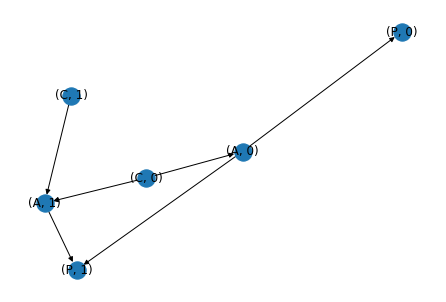

In [20]:
import networkx as nx
import pylab as plt
nx_graph = nx.DiGraph(dbnet.edges())
nx.draw(nx_graph, with_labels=True)
plt.show()